# Import the libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import TimeSeriesSplit


# Load the dataset

PJM Hourly Energy Consumption Data

PJM Interconnection LLC (PJM) is a regional transmission organization (RTO) in the United States. It is part of the Eastern Interconnection grid, operating an electric transmission system that serves all or parts of Delaware, Illinois, Indiana, Kentucky, Maryland, Michigan, New Jersey, North Carolina, Ohio, Pennsylvania, Tennessee, Virginia, West Virginia, and the District of Columbia.

The hourly power consumption data is sourced from PJM's website and is measured in megawatts (MW).

The regions have evolved over the years, so data may only be available for certain dates within specific regions.

In [2]:
df = pd.read_csv('PJME_hourly.csv')
df.head()

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [3]:
# Set 'Datetime' column as index and convert it to datetime
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)
df = df.sort_index()
df.head()

,PJME_MW
Datetime,
2002-01-01 01:00:00,30393.0
2002-01-01 02:00:00,29265.0
2002-01-01 03:00:00,28357.0
2002-01-01 04:00:00,27899.0
2002-01-01 05:00:00,28057.0


# Data Exploration 
The initial plots provide a visual understanding of the data distribution and seasonal patterns.

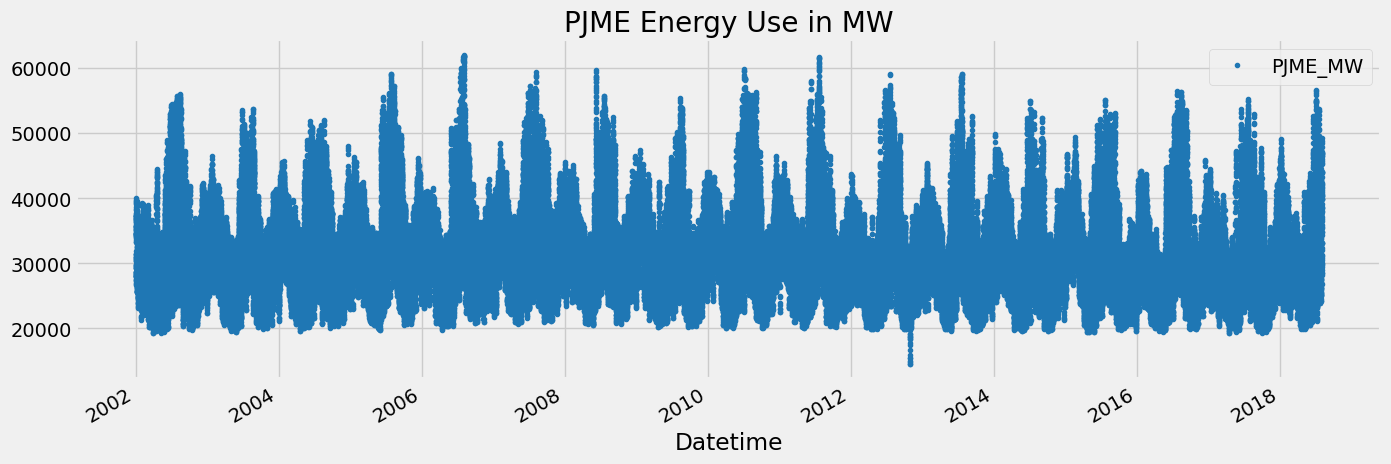

In [4]:
# Set color palette and plotting style
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

# Plot the entire dataset
df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='PJME Energy Use in MW')
plt.show()

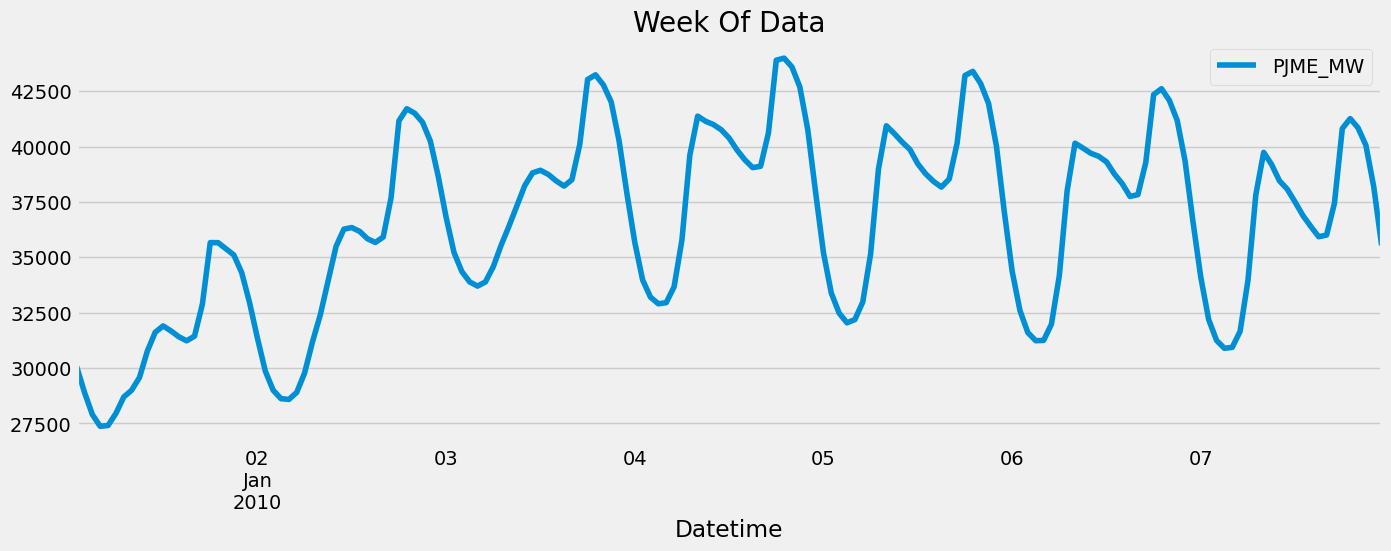

In [5]:
# Filter the DataFrame to select rows where the index is between '01-01-2010' and '01-08-2010'
# This allows us to focus on a specific week of data 
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')] \
    .plot(figsize=(15, 5), title='Week Of Data')  

plt.show()


We can see in the chart that between the years 2012 and 2014, there was an unusual moment of low consumption that we could consider as outliers.

<Axes: ylabel='Frequency'>

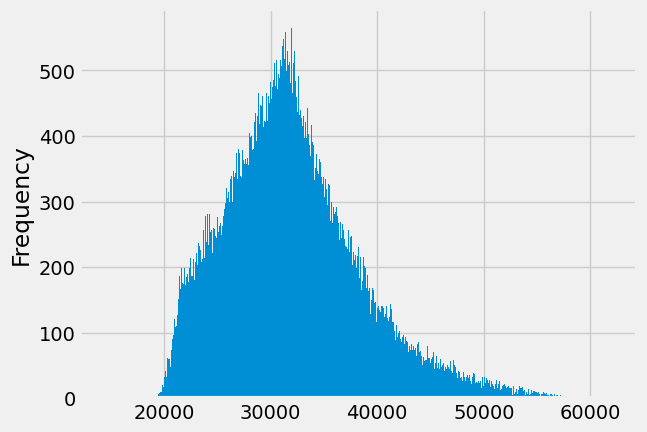

In [6]:
df['PJME_MW'].plot(kind='hist', bins=1000)


<Axes: title={'center': 'Outliers'}, xlabel='Datetime'>

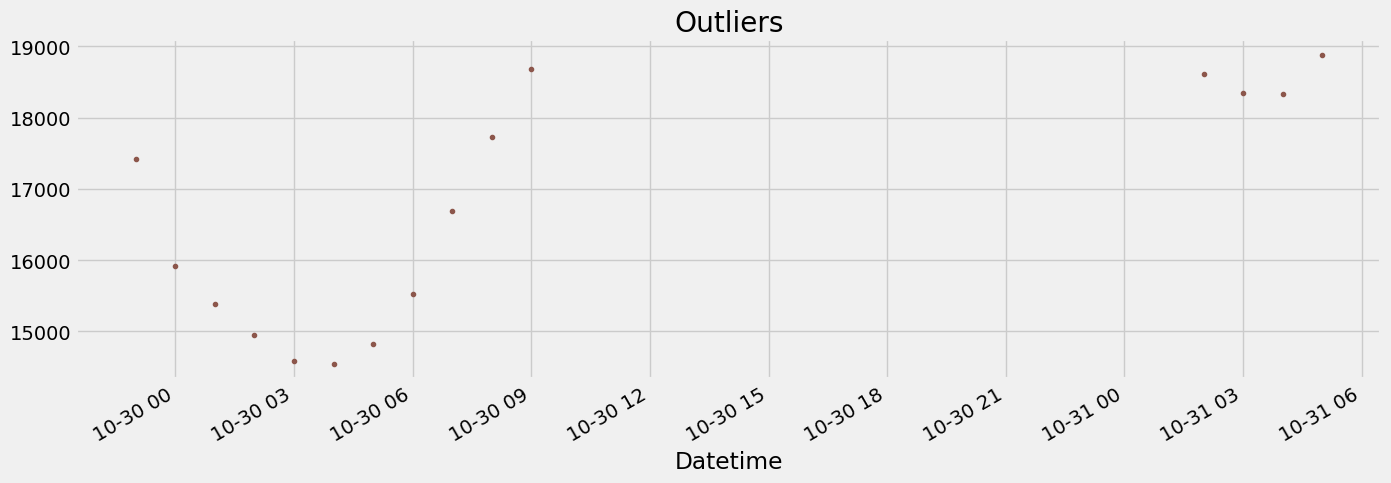

In [7]:
# Plot data points where PJME_MW is below 19,000 to visualize potential outliers
df.query('PJME_MW < 19_000')['PJME_MW'] \
    .plot(style='.',
          figsize=(15, 5),
          color=color_pal[5],
          title='Outliers')

In [8]:
# Filter the DataFrame to retain only data points where PJME_MW is greater than 19,000 MW
# This helps in removing outliers or extremely low consumption values for further analysis
df = df.query('PJME_MW > 19_000').copy()

In [9]:
def create_features(df):
    """
    Create time series features based on time series index.
    
    This function generates new features from the DataFrame index (which is expected to be a datetime index).
    The features created include:
    - 'hour': Hour of the day 
    - 'dayofweek': Day of the week (0=Monday, 6=Sunday)
    - 'quarter': Quarter of the year 
    - 'month': Month of the year 
    - 'year': Year extracted from the date
    - 'dayofyear': Day of the year 
    - 'dayofmonth': Day of the month 
    - 'weekofyear': Week of the year according to ISO calendar
    
    These features can be useful for time series analysis and forecasting, as they allow the model to capture seasonal patterns and trends based on temporal information.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

def add_lags(df):
    """
    Add lagged features to the DataFrame for the target variable 'PJME_MW'.
    
    This function creates three lagged features based on the previous year's data,
    allowing the model to leverage past values of the target variable for forecasting.
    
    The following lagged features are created:
    - 'lag1': Value of 'PJME_MW' from 364 days ago (1 year)
    - 'lag2': Value of 'PJME_MW' from 728 days ago (2 years)
    - 'lag3': Value of 'PJME_MW' from 1092 days ago (3 years)
    
    Using 364 days instead of 365 ensures that the lagged value falls on the same
    day of the week, which is important for capturing consistent weekly patterns 
    (e.g., weekends, weekdays). This helps preserve the weekly seasonality in the 
    time series data, as 364 is divisible by 7.
    
    These lagged features can help capture trends and seasonality in the time series data.
    """
    target_map = df['PJME_MW'].to_dict()  # Convert the target variable to a dictionary for quick lookup
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)  # 1-year lag
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)  # 2-year lag
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)  # 3-year lag
    return df

df = add_lags(df)


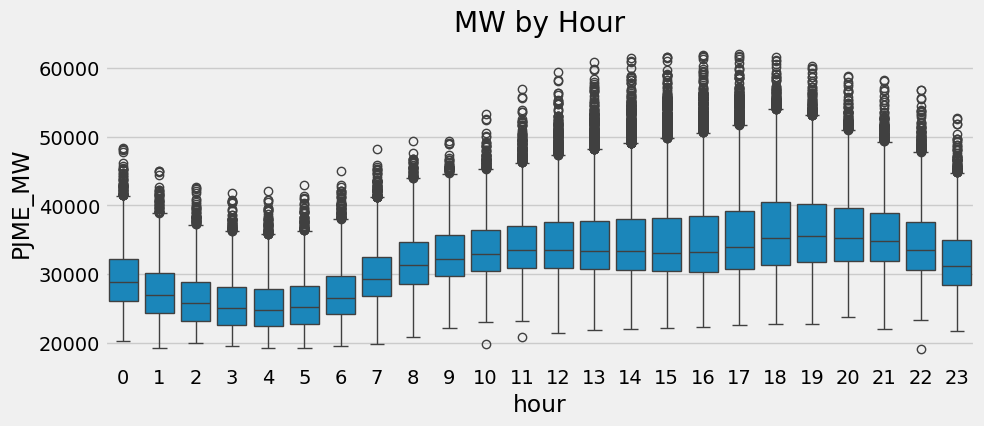

In [10]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.boxplot(data=df, x='hour', y='PJME_MW')
ax.set_title('MW by Hour')
plt.show()

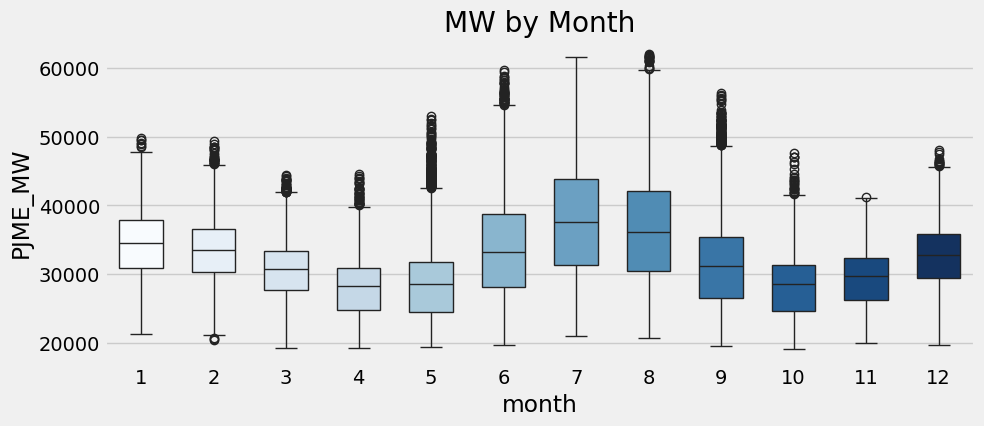

In [11]:
fig, ax = plt.subplots(figsize=(10, 4))

# Usamos 'month' en el eje hue para asignar colores
sns.boxplot(data=df, x='month', y='PJME_MW', hue='month', palette='Blues', width=0.6, ax=ax)

# Deshabilitar la leyenda, ya que no es necesaria
ax.legend_.remove()

ax.set_title('MW by Month')
plt.show()


# Time Series Cross Validation

In [12]:
# Initialize TimeSeriesSplit with 5 splits, each with a test size of one year (24 hours * 365 days)
# The gap of 24 hours ensures that the training set ends 24 hours before the test set starts, preventing data leakage
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)

# Sort the DataFrame by index to ensure the time series is in chronological order before splitting
df = df.sort_index()


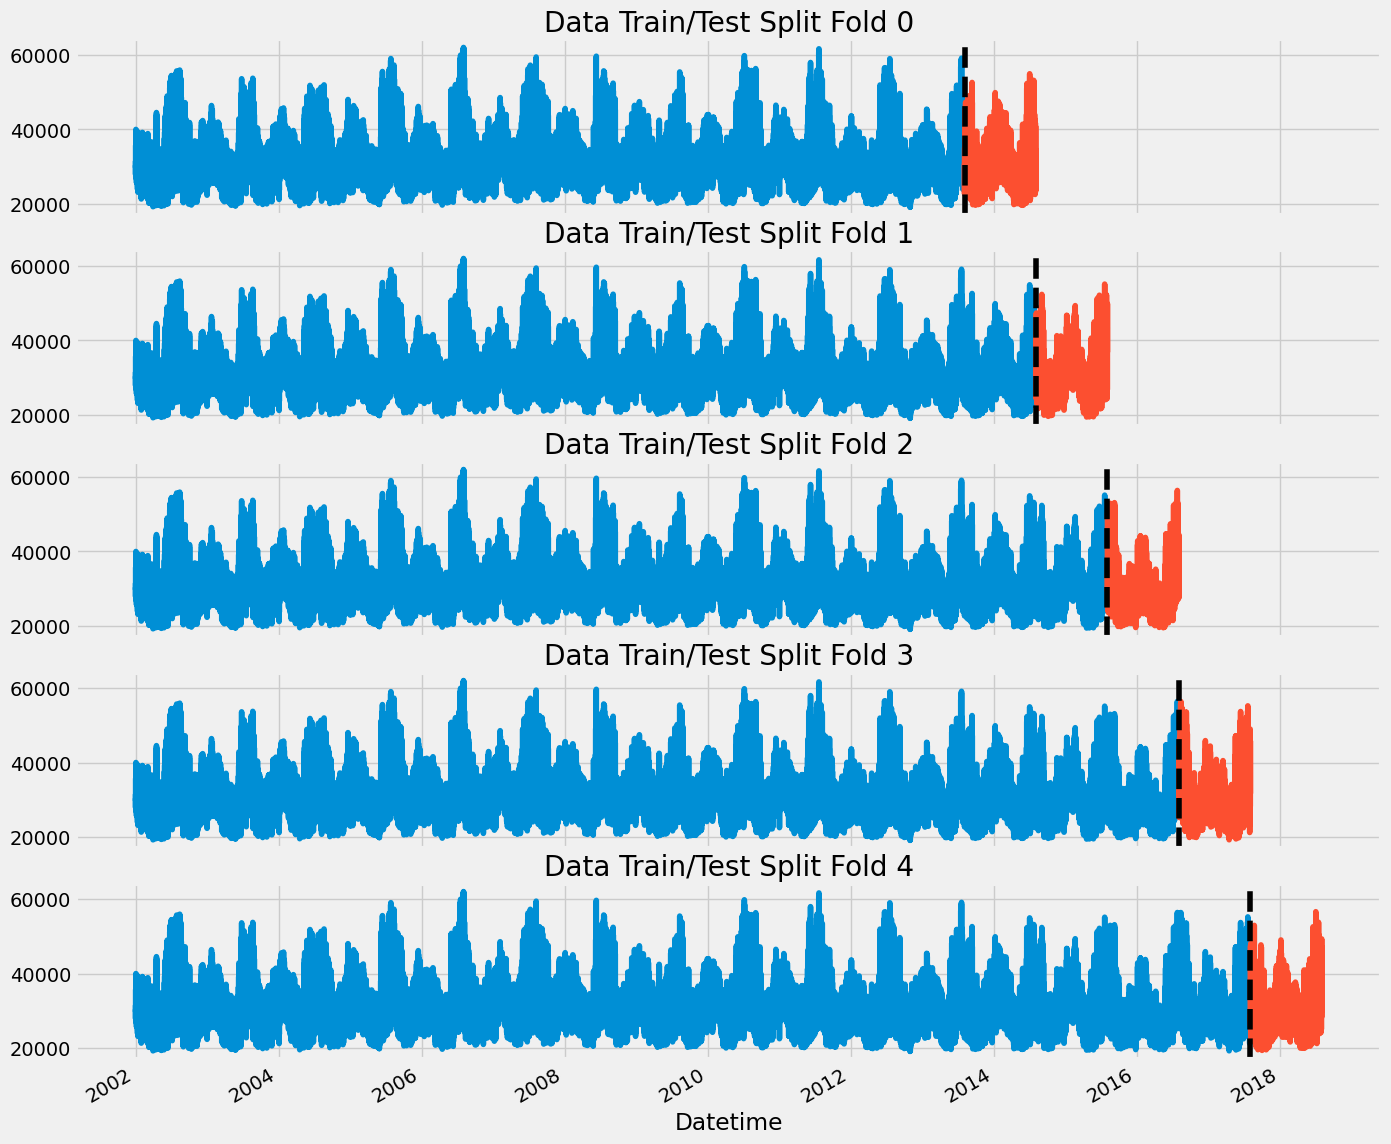

In [13]:
# Create a figure with 5 subplots for visualizing the train/test splits for each fold
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0

# Iterate through each train/test split generated by TimeSeriesSplit
for train_idx, val_idx in tss.split(df):

    # Extract the training and test sets based on the indices
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    
    # Plot the training set on the corresponding subplot
    train['PJME_MW'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    # Plot the test set on the same subplot
    test['PJME_MW'].plot(ax=axs[fold],
                         label='Test Set')
    
    # Add a vertical line to indicate where the test set starts
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    
    # Increment the fold counter
    fold += 1

# Show the plot with all folds visualized
plt.show()


In [14]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()

fold = 0
preds = []
scores = []

# Loop over each split created by TimeSeriesSplit
for train_idx, val_idx in tss.split(df):
    # Separate training and test sets based on the split
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    # Create time-based features for both training and test sets
    train = create_features(train)
    test = create_features(test)

    # Define the features to use for prediction
    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year',
                'lag1', 'lag2', 'lag3']
    TARGET = 'PJME_MW'

    # Split the data into inputs (X) and target (y) for both training and test sets
    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    # Define the XGBoost regressor model
    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,               # Maximum number of trees
                           early_stopping_rounds=50,        # Stop early if no improvement
                           objective='reg:squarederror',    # Use 'reg:squarederror' for regression
                           max_depth=3,                     # Tree depth
                           learning_rate=0.01)              # Learning rate

    # Train the model with the training data and evaluate on both train and test sets
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    # Predict on the test set
    y_pred = reg.predict(X_test)
    preds.append(y_pred)

    # Calculate the Root Mean Squared Error (RMSE) for this fold
    score = np.sqrt(root_mean_squared_error(y_test, y_pred))
    scores.append(score)

    # Increment fold count
    fold += 1


[0]	validation_0-rmse:32732.49608	validation_1-rmse:31956.60163
[100]	validation_0-rmse:12532.64369	validation_1-rmse:11906.14134
[200]	validation_0-rmse:5747.92495	validation_1-rmse:5359.26490
[300]	validation_0-rmse:3872.48134	validation_1-rmse:3900.86965
[400]	validation_0-rmse:3434.23853	validation_1-rmse:3762.33705
[441]	validation_0-rmse:3370.76149	validation_1-rmse:3764.48078
[0]	validation_0-rmse:32672.16678	validation_1-rmse:32138.89241
[100]	validation_0-rmse:12513.65574	validation_1-rmse:12224.93373
[200]	validation_0-rmse:5753.34937	validation_1-rmse:5662.07107
[300]	validation_0-rmse:3902.71304	validation_1-rmse:3933.73076
[400]	validation_0-rmse:3476.90515	validation_1-rmse:3590.55005
[500]	validation_0-rmse:3353.72424	validation_1-rmse:3516.39915
[600]	validation_0-rmse:3297.94766	validation_1-rmse:3481.94003
[700]	validation_0-rmse:3258.48267	validation_1-rmse:3461.37383
[800]	validation_0-rmse:3221.51553	validation_1-rmse:3436.49603
[900]	validation_0-rmse:3190.11480	v

In [15]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 61.1235
Fold scores:[61.32558779790321, 58.483442886751114, 58.97415028688829, 63.62888465856309, 63.205245006613765]


# Predicting the future

In [16]:
# Retrain on all data after feature creation
df = create_features(df)

# Define the features and target variable
FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year',
            'lag1', 'lag2', 'lag3']
TARGET = 'PJME_MW'

# Prepare the feature matrix (X) and target vector (y) for all data
X_all = df[FEATURES]
y_all = df[TARGET]

# Initialize the XGBoost regressor
reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',
                       n_estimators=500,  # Reduced from 1000 in cross-validation to avoid overfitting
                       objective='reg:squarederror',
                       max_depth=3,
                       learning_rate=0.01)

# Fit the model to the entire dataset
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],  # Evaluate on the training set
        verbose=100)  # Print the evaluation results every 100 iterations


[0]	validation_0-rmse:32403.88991
[100]	validation_0-rmse:12426.77634
[200]	validation_0-rmse:5753.18185
[300]	validation_0-rmse:3970.09750
[400]	validation_0-rmse:3569.04143
[499]	validation_0-rmse:3456.41787


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

# Feature Importance

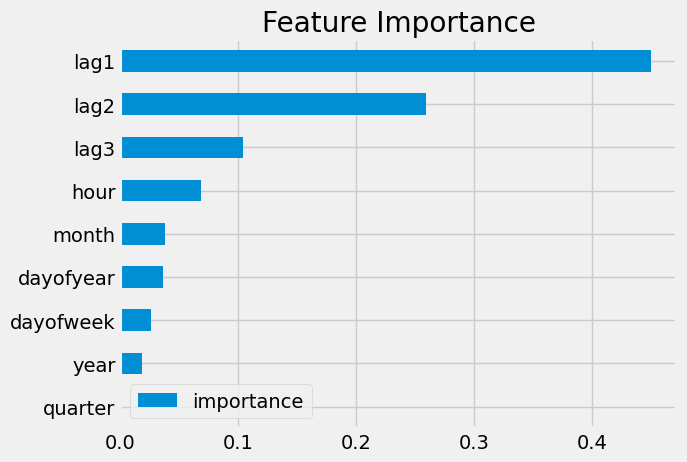

In [17]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

In [18]:
# Find the most recent timestamp in the DataFrame's index
df.index.max()

Timestamp('2018-08-03 00:00:00')

In [19]:
# Create a future DataFrame with a date range from '2018-08-03' to '2019-08-01', with hourly frequency
future = pd.date_range('2018-08-03', '2019-08-01', freq='1h')

future_df = pd.DataFrame(index=future)

# Add a column 'isFuture' to mark these future data points
future_df['isFuture'] = True

# In the original DataFrame, add a column 'isFuture' to mark existing data as non-future
df['isFuture'] = False

# Combine the original DataFrame and the future DataFrame
df_and_future = pd.concat([df, future_df])

# Apply the create_features function to both past and future data
df_and_future = create_features(df_and_future)

# Apply the add_lags function to both past and future data
df_and_future = add_lags(df_and_future)

In [20]:
# Create a new DataFrame containing only the future data points
future_w_features = df_and_future.query('isFuture').copy()

In [21]:
# Use the trained model to make predictions on the future data points
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

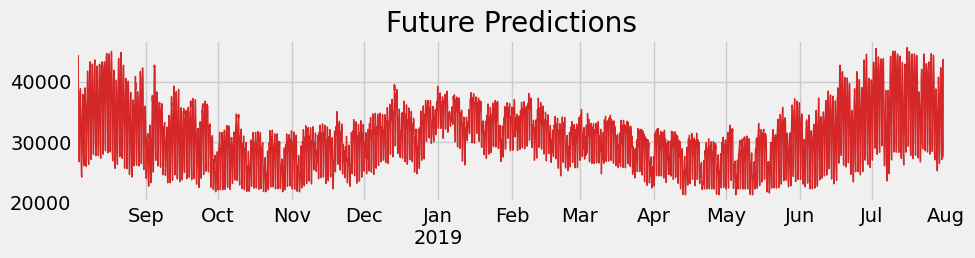

In [22]:
# Plot the future predictions
future_w_features['pred'].plot(figsize=(10, 2),
                               color=color_pal[3],  
                               ms=1,                
                               lw=1,               
                               title='Future Predictions')  
plt.show()  # Display the plot

# Saving Model

In [23]:
reg.save_model('model.json')